<a id='project_explanation'></a>
# Brief Explanation of This Project
In this project, I aim to somewhat replicate the epigenetic clock developed by Horvath, using methylation data taken from blood samples to predict an individual's age. The datasets and methylation sites chosen for this project were advised by the research paper titled [Human Age Prediction Based on DNA Methylation Using a Gradient Boosting Regressor](https://doi.org/10.3390/genes9090424). Other than the differences in the datasets used, there is one notable difference between the paper and this code:
This notebook contains three different ML Regression algorithms and a Deep Neural Network, and compares the performance of each model on the training and testing dataset. The four models developed in this notebook are: Multivariable Linear Regression, Random Forest Regression, Gradient Boosting Regression, and a Deep Neural Network.

In [1]:
!pip install yellowbrick

     |████████████████████████████████| 282 kB 18.4 MB/s eta 0:00:01


In [2]:
import pandas as pd

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import seaborn as sb

import numpy as np

import os

import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

import pickle

In [3]:
std_scaler = StandardScaler()
std_scaler

StandardScaler()

<a id='healthy_data_prep'></a>
# Preparing the Healthy Patient Data

In [4]:
# Loading methylation dataset using Pandas
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_73f80164cc8d4453ace2ccaeedb9f5d6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='VYXxHk8wVJtTbga8SSe0x4xSvEWDbYiZOzWdyeuLSHa8',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

body = client_73f80164cc8d4453ace2ccaeedb9f5d6.get_object(Bucket='bioage-donotdelete-pr-re6stby4ah9ab4',Key='Healthy_Methylation_Dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

healthy_df = pd.read_csv(body)
healthy_df.head()


,...1,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM507152,0.392464,0.281630,0.352591,0.315924,0.111604,0.211683,1,71.06
1,GSM507153,0.377919,0.238900,0.520396,0.323641,0.127965,0.184307,1,69.65
2,GSM507154,0.458522,0.204078,0.519273,0.363714,0.119891,0.215067,1,65.79
3,GSM507155,0.479108,0.154893,0.618859,0.493972,0.088941,0.240057,1,49.39
4,GSM507156,0.418763,0.217832,0.561005,0.398580,0.085992,0.207462,1,60.68


Here we first shuffle our dataset to remove any confounding factors that may exist as a result of the ordering of the dataset, such as an inappropriate train-test split. We also drop all rows with missing values (or NaNs), and reset the indices afterward.

In [5]:
# Shuffle dataframe to randomize data order, possibly preventing confounding factors
healthy_df = shuffle(healthy_df)

# Remove patient ID column
healthy_df = healthy_df.drop(['...1'], axis=1)

# Drop all rows with NaN values
healthy_df = healthy_df.dropna()

# Reset Index
healthy_df.reset_index(inplace=True, drop=True)

healthy_df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,0.861134,0.030339,0.772940,0.764273,0.038618,0.407311,1,0.00
1,0.665470,0.111330,0.644090,0.528570,0.050360,0.325280,0,4.25
2,0.613737,0.231627,0.798076,0.392510,0.179445,0.307907,0,32.00
3,0.847000,0.076200,0.781000,0.762000,0.030100,0.416000,0,0.00
4,0.875370,0.127060,0.704220,0.589560,0.014410,0.668570,1,0.00


In [6]:
# Checking if there are any remaining NaNs in the dataset
np.where(pd.isnull(healthy_df))

(array([], dtype=int64), array([], dtype=int64))

Below, we plot the correlation matrix, or heatmap, to compare the variables. As can be seen in the lowest row (labelled age),  the methylation sites that might be the best predictors of age (the most strongly correlated, whether negative or positive) are cg09809672, cg01820374, and cg19761273.
We also see that sex seems to have a positive positive correlation with age. This suggests a possible confounding factor that may arise as a result of the dataset, since it seems that the females in the dataset (labelled as 1) are older than the males (labelled 0).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


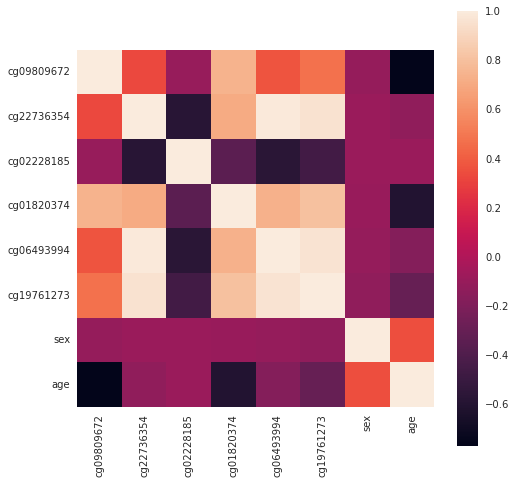

In [7]:
# Plot correlation matrix, or heatmap, to compare variables. As can 
# be seen in the lowest row (labelled age), the methylation sites
# that might act as the best predictors of age are cg09809672,
# cg01820374, and cg19761273.
C_mat = healthy_df.corr()
fig = plt.figure(figsize = (8,8))

sb.heatmap(C_mat, vmax=1, square=True)
plt.show()

In [8]:
# Normalizing the methylation and sex data with a Standard Scaler.
X = healthy_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'sex']]

# Separating X vs. y dataframes
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
y = healthy_df['age']

In [9]:
# Separating dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

<a id='model_training'></a>
# Training the Models

<a id='linear_regression'></a>
## Linear Regression Model

Based on the score and predictions printed below, we see that the linear regression model is only somewhate capable of accurately predicting the age of an individual using the methylation levels inputted, with roughly 75% testing accuracy (varies with each run).

In [10]:
# Training the multivariate linear regression model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(linear_regressor.score(X_test, y_test))

0.7450804768238184


In [11]:
predictions = linear_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
    print("Prediction:", predictions[i], "\tActual:", y_test.iloc[i])

Prediction: 49.69820552677105 	Actual: 68.2
Prediction: 1.3969793266411585 	Actual: 0.0
Prediction: 42.4869896955459 	Actual: 60.9
Prediction: 17.31480821255346 	Actual: 17.0
Prediction: 3.191848954488151 	Actual: 0.0
Prediction: 12.756959396381212 	Actual: 12.91666667
Prediction: 18.84385317782707 	Actual: 13.41666667
Prediction: 35.28193643181629 	Actual: 30.0
Prediction: 9.302843569441066 	Actual: 5.916666667
Prediction: 0.0 	Actual: 0.0


<a id='random_forest_regression'></a>
## Random Forest Regression Model

Looking at the score for the model below, we can see that the Random Forest Regressor model is quite accurate at predicting an individual's age using their methylation data, with roughly 92% testing accuracy (varies with each run).

In [12]:
# Building and training the Random Forest Regressor model
# Optimal value for n_estimators was determined by trial and error, comparing the score for each trial
random_forest_regressor = RandomForestRegressor(n_estimators = 17, random_state = 0)
random_forest_regressor.fit(X_train, y_train)

# Accuracy on the testing set
test_acc = random_forest_regressor.score(X_test, y_test)
print(test_acc)

0.9302161785526581


In [13]:

# # @hidden_cell
# # The following code contains the credentials for a file in your IBM Cloud Object Storage.
# # You might want to remove those credentials before you share your notebook.
# credentials_2 = {
#     'IAM_SERVICE_ID': 'iam-ServiceId-5602c48e-5bfa-492b-a787-87252581b953',
#     'IBM_API_KEY_ID': 'VYXxHk8wVJtTbga8SSe0x4xSvEWDbYiZOzWdyeuLSHa8',
#     'ENDPOINT': 'https://s3.private.eu.cloud-object-storage.appdomain.cloud',
#     'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
#     'BUCKET': 'bioage-donotdelete-pr-re6stby4ah9ab4',
#     'FILE': 'Saved Model.zip'
# }

# if (os.path.exists(credentials_1.FILE)):
#     random_forest_regressor_load = pickle.load(open(filepath, 'rb'))
#     if (random_forest_regressor_load.score(X_test, y_test) > test_acc):
#         random_forest_regressor = random_forest_regressor_load
#     else:
#         pickle.dump(random_forest_regressor, open(filepath, 'wb'))
# else:
#     pickle.dump(random_forest_regressor, open(filepath, 'wb'))

In [14]:
predictions = random_forest_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
    print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 67.63982352941176 	Actual: 68.2
Prediction: 0.754901960764706 	Actual: 0.0
Prediction: 61.47823529411764 	Actual: 60.9
Prediction: 17.63235294117647 	Actual: 17.0
Prediction: 0.0 	Actual: 0.0
Prediction: 8.235294117352941 	Actual: 12.91666667
Prediction: 13.014705882764705 	Actual: 13.41666667
Prediction: 30.235294117647058 	Actual: 30.0
Prediction: 7.563725491529412 	Actual: 5.916666667
Prediction: 0.0 	Actual: 0.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


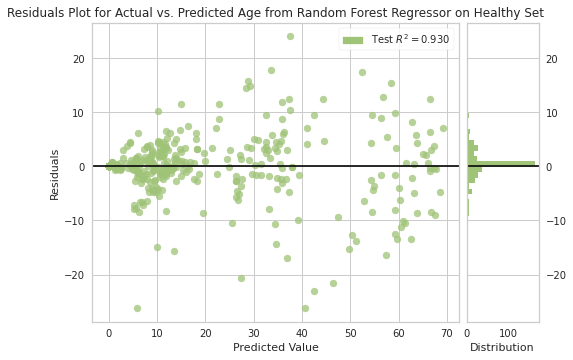

<AxesSubplot:title={'center':'Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Healthy Set'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
visualizer = ResidualsPlot(random_forest_regressor, title="Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Healthy Set")

visualizer.score(X_test, y_test)
visualizer.show()

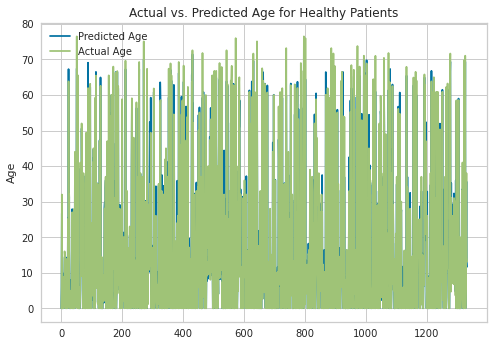

In [16]:
predictions = random_forest_regressor.predict(X)
plt.plot(predictions)
plt.plot(y)
plt.title("Actual vs. Predicted Age for Healthy Patients")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

<a id='gradient_boosting_regression'></a>
## Gradient Boosting Regression Model

Looking at the two code blocks below, we see that the Gradient Boosting Regressor model, though not as accurate as the Random Forest Regressor, is still fairly accurate at generating the predictions using the data given, with roughly 86% accuracy on the testing set (varies with each run).

In [17]:
# Building and training the Gradient Boosting Regressor model

# The values of n_estimators, max_depth, and learning_rate were determined by trial and error,
# to obtain the obtimal values shown below.
params = {'n_estimators':3, 'max_depth':3, 'learning_rate': 1, 'criterion': 'mse'}

gradient_boosting_regressor = GradientBoostingRegressor(**params)
gradient_boosting_regressor.fit(X_train, y_train)

print(gradient_boosting_regressor.score(X_test, y_test))

0.8668516631075353


/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:471: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


In [18]:
predictions = gradient_boosting_regressor.predict(X_test)
for i in range(0, 10):
    if predictions[i] < 0:
        predictions[i] = 0
    print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 59.03515381382752 	Actual: 68.2
Prediction: 10.343611240171908 	Actual: 0.0
Prediction: 59.00791485026843 	Actual: 60.9
Prediction: 12.236364603357055 	Actual: 17.0
Prediction: 0.0402856720888467 	Actual: 0.0
Prediction: 10.343611240171908 	Actual: 12.91666667
Prediction: 11.144697440800797 	Actual: 13.41666667
Prediction: 33.11370742763506 	Actual: 30.0
Prediction: 7.266364223327797 	Actual: 5.916666667
Prediction: 0.0402856720888467 	Actual: 0.0


<a id='regressive_neural_network'></a>
## Regressive Neural Network

In [19]:
# Creating the sequential neural network model
NN_model = Sequential()

# Input layer
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# Output layer
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))


# Compile NN
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


As seen in the plots showing the accuracy and loss as the model continues training, or the evaluation in the very last block, the neural network is extremely poor at predicting an individual's age, with an accuracy of around 30% (varies with each run).

In [20]:
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, verbose=0)

In [21]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'accuracy', 'val_loss', 'val_mean_absolute_error', 'val_accuracy'])


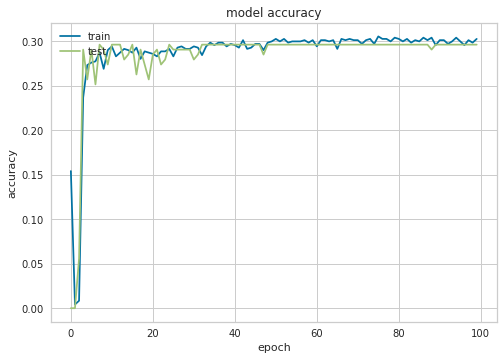

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

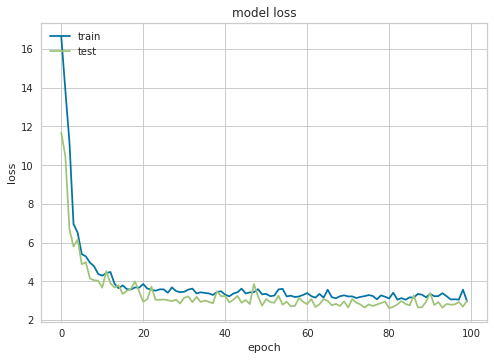

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
evaluation = NN_model.evaluate(X_test, y_test, batch_size=32)
loss = evaluation[0]
acc = evaluation[2]
print("Test loss:", loss)
print("Test accuracy:", acc)

14/14 [==============================] - 0s 3ms/step - loss: 3.1403 - mean_absolute_error: 3.1403 - accuracy: 0.2880
Test loss: 3.1402676105499268
Test accuracy: 0.28798186779022217


<a id='model_training_conclusion'></a>
## Conclusion
With the code seen above, we conclude that the Random Forest Regression model is the best model of the four, and is able to fairly accurately predict an individual's age using their methylation levels at the 6 sites. Not far behind in accuracy is the Gradient Boosting model. The Linear Regression model is not as accurately able to predict the age, but is still able to do so much much more accurately than the neural network, which was only able to achieve a testing accuracy of roughly 30%, and validation accuracy ranging from 30-35%.

<a id='testing_diseased_patients'></a>
# Testing on Diseased Patients

Some of the models developed above are capable of accurately predicting the age of healthy individuals based on their methylation levels. However, if biological age is really a marker of one's health, then it should be expected that unhealthy individuals (or diseased individuals) should display methylation levels corresponding with a worse biological age. To test this, we import a large dataset of around 627 diseased individuals (after removing NaNs) and use the Random Forest Regressor (the model with the highest accuracy in the previous dataset) to compare the predicted biological age to their actual chronological age.

In [25]:
 
body = client_73f80164cc8d4453ace2ccaeedb9f5d6.get_object(Bucket='bioage-donotdelete-pr-re6stby4ah9ab4',Key='Disease_Methylation_Dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

disease_df = pd.read_csv(body)
disease_df.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM501487,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1.0,17.0
1,GSM501488,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0.0,15.0
2,GSM501489,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0.0,13.0
3,GSM501490,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0.0,22.0
4,GSM501491,0.665320,0.146727,0.627872,0.420957,0.093538,0.216396,0.0,29.0


In [26]:
# Remove patient ID column
disease_df = disease_df.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
disease_df = disease_df.dropna()

disease_df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1.0,17.0
1,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0.0,15.0
2,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0.0,13.0
3,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0.0,22.0
4,0.665320,0.146727,0.627872,0.420957,0.093538,0.216396,0.0,29.0


In [27]:
disease_X = disease_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'sex']]
disease_X = pd.DataFrame(std_scaler.fit_transform(disease_X), columns=disease_X.columns)
disease_Y = disease_df['age']
disease_predictions = []

try:
    disease_predictions = random_forest_regressor.predict(disease_X)
except NameError:
    if (os.path.exists('Saved Model/finalized_RFR_model.sav')):
        random_forest_regressor = pickle.load(open('Saved Model/finalized_RFR_model.sav', 'rb'))
        disease_predictions = random_forest_regressor.predict(disease_X)
    else:
        print("Please train the random forest regressor first.")

<a id='whole_comparison'></a>
## Comparing the Actual and Predicted Ages

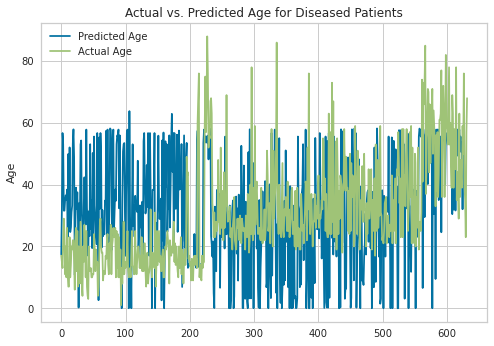

In [28]:
plt.plot(disease_predictions)
plt.plot(disease_Y)
plt.title("Actual vs. Predicted Age for Diseased Patients")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

As seen above, it seems that there is a chance that the predicted age is often lower than the actual age of many patients. To verify this, we plot a residual plot of the data below.

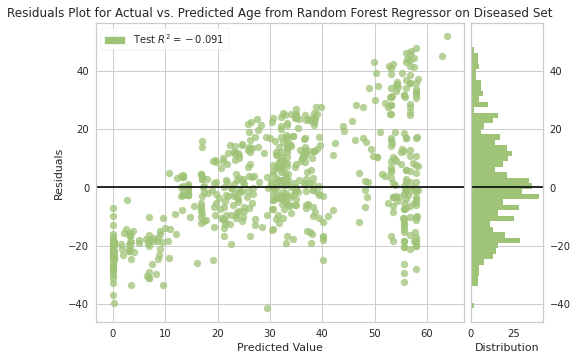

<AxesSubplot:title={'center':'Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Diseased Set'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
visualizer = ResidualsPlot(random_forest_regressor, title="Residuals Plot for Actual vs. Predicted Age from Random Forest Regressor on Diseased Set")

visualizer.score(disease_X, disease_Y)
visualizer.show()

The residual plot shows a roughly normal distribution with an average residual (estimated by looking at the graph) close to 0. This suggests that the age predicted by the random forest regressor model trained above is not far from the actual age of the individual. This is interesting, since based on a lot of research that has been conducted by longevity scientists, individuals suffering from a chronic disease are generally biologically older than healthy individuals of the same age.

In [30]:
residuals = []
for i in range(0, len(disease_predictions)):
    residuals.append(disease_predictions[i] - disease_Y.iloc[i])
d = {'Actual Age': disease_Y, 'Predicted Age': disease_predictions, 'Residual (Actual - Predicted)': residuals}
disease_prediction_df = pd.DataFrame(data=d, dtype='int64')
disease_prediction_df.head()

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/pandas/core/internals/construction.py:464: FutureWarning: In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)
  return arrays_to_mgr(
/tmp/wsuser/ipykernel_164/876314546.py:5: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  disease_prediction_df = pd.DataFrame(data=d, dtype='int64')


,Actual Age,Predicted Age,Residual (Actual - Predicted)
0,17,17,0.387255
1,15,32,17.176471
2,13,56,43.713119
3,22,53,31.098413
4,29,31,2.580588


Based on the graph comparing predicted vs. actual age over the entire diseased dataset (see [here](#whole_comparison)), we can see that there appears to be a few clearly distinct patterns throughout the graph, divided into distinct regions. This is likely due to the different diseases cohorts in the overall dataset, and so, to examine the effects of different diseases on the predicted vs. actual age comparison, we conduct smaller scale comparisons with each individual disease subset below.

<a id='GSE20067'></a>
## Type 1 Diabetes Cohort - GSE20067

The first subset, GSE20067, is made of 194 Irish patients suffering from type 1 diabetes (T1D), which is caused by a dysfunctional pancreas that produces little or no insulin. You can find out more about T1D here: [Type 1 Diabetes](https://www.mayoclinic.org/diseases-conditions/type-1-diabetes/symptoms-causes/syc-20353011).

In [31]:

body = client_73f80164cc8d4453ace2ccaeedb9f5d6.get_object(Bucket='bioage-donotdelete-pr-re6stby4ah9ab4',Key='GSE20067.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

GSE20067 = pd.read_csv(body)
GSE20067.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM501487,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1,17
1,GSM501488,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0,15
2,GSM501489,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0,13
3,GSM501490,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0,22
4,GSM501491,0.665320,0.146727,0.627872,0.420957,0.093538,0.216396,0,29


In [32]:
# Remove patient ID column
GSE20067 = GSE20067.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE20067 = GSE20067.dropna()

GSE20067_X = GSE20067[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'sex']]
GSE20067_X = pd.DataFrame(std_scaler.fit_transform(GSE20067_X), columns=GSE20067_X.columns)
GSE20067_Y = GSE20067['age']

GSE20067_predictions = random_forest_regressor.predict(GSE20067_X)

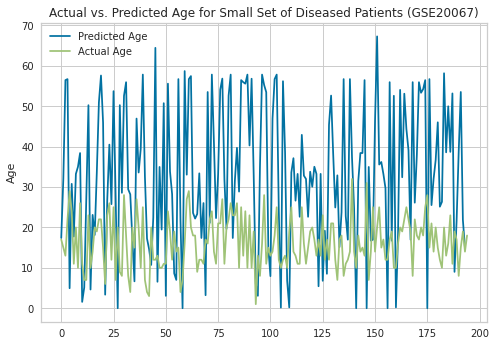

In [33]:
plt.plot(GSE20067_predictions)
plt.plot(GSE20067_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE20067)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

Above we see that, for this sample, the relation between actual and predicted age matches the pattern observed by longevity researchers, where we see that predicted age is often larger (by as much as 50 years for some patients) than the actual age for the diseased individuals. The same result can be observed in the residual plot below, which shows that the majority of residuals are positive, with an estimated mean residual (simply by looking at the graph) of positive 20-30 years.

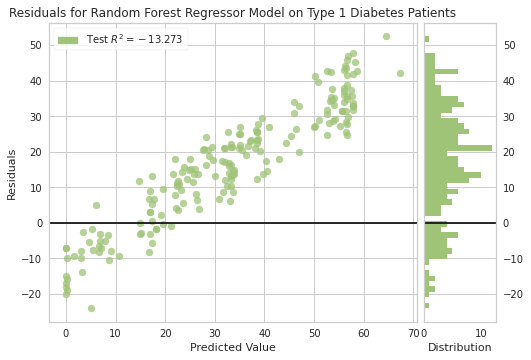

<AxesSubplot:title={'center':'Residuals for Random Forest Regressor Model on Type 1 Diabetes Patients'}, xlabel='Predicted Value', ylabel='Residuals'>

In [34]:
visualizer = ResidualsPlot(random_forest_regressor, title="Residuals for Random Forest Regressor Model on Type 1 Diabetes Patients")

visualizer.score(GSE20067_X, GSE20067_Y)
visualizer.show()

<a id='GSE41037'></a>
## Schizophrenia Cohort - GSE41037

GSE41037 is made up of 323 patients suffering from schizophrenia. Find out more about schizophrenia [here](https://www.mayoclinic.org/diseases-conditions/schizophrenia/symptoms-causes/syc-20354443#:~:text=Schizophrenia%20is%20a%20serious%20mental,functioning%2C%20and%20can%20be%20disabling.).

In [35]:

body = client_73f80164cc8d4453ace2ccaeedb9f5d6.get_object(Bucket='bioage-donotdelete-pr-re6stby4ah9ab4',Key='GSE41037.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

GSE41037 = pd.read_csv(body)
GSE41037.head()


,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM1007129,0.546674,0.102902,0.701616,0.403573,0.077722,0.200886,0.0,34
1,GSM1007130,0.520461,0.125784,0.732437,0.412626,0.084386,0.238607,0.0,31
2,GSM1007131,0.449827,0.094724,0.573047,0.510932,0.049334,0.258955,0.0,23
3,GSM1007132,0.485862,0.130506,0.625189,0.574476,0.074315,0.236753,0.0,31
4,GSM1007133,0.557721,0.089979,0.716201,0.451005,0.086806,0.309545,0.0,23


In [36]:
# Remove patient ID column
GSE41037 = GSE41037.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE41037 = GSE41037.dropna()

GSE41037_X = GSE41037[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'sex']]
GSE41037_X = pd.DataFrame(std_scaler.fit_transform(GSE41037_X), columns=GSE41037_X.columns)
GSE41037_Y = GSE41037['age']

GSE41037_predictions = random_forest_regressor.predict(GSE41037_X)

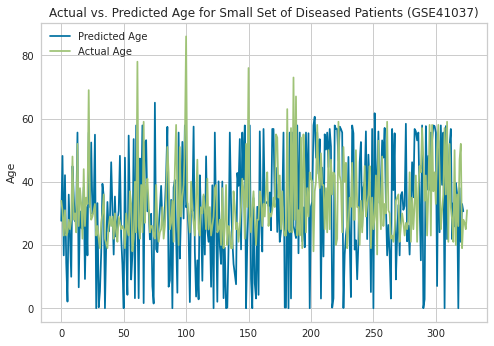

In [37]:
plt.plot(GSE41037_predictions)
plt.plot(GSE41037_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE41037)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

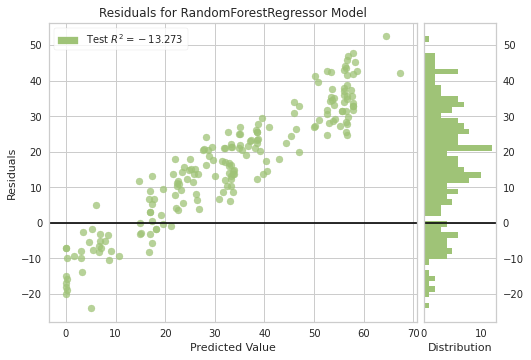

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [38]:
visualizer = ResidualsPlot(random_forest_regressor)

visualizer.score(GSE20067_X, GSE20067_Y)
visualizer.show()

The data above also shows results where the predicted bio-age was generally higher than the actual age, suggesting that schizophrenia does induce epigenetic changes even in the blood, which is intriguing since schizophrenia is more commonly thought of as being restricted to the nervous system in its effects. However, such observations have been widely categorized in schizophrenia patients ([Schizophrenia biomarkers: translating the descriptive into the diagnostic](https://pubmed.ncbi.nlm.nih.gov/25601396/)), with one study ([Epigenetic aberrations in leukocytes of patients with schizophrenia: association of global DNA methylation with antipsychotic drug treatment and disease onset](https://pubmed.ncbi.nlm.nih.gov/22426120/))finding global hypomethylation (reduced methylation across the genome) in white blood cells, showing that schizophrenia is not limited to the brain but does induce damage across the body.

<a id='GSE49904'></a>
## Normal Ageing Population Cohort - GSE49904

GSE49904 is made up of the epigenetic data collected from 71 patients of different ages.

In [39]:

body = client_73f80164cc8d4453ace2ccaeedb9f5d6.get_object(Bucket='bioage-donotdelete-pr-re6stby4ah9ab4',Key='GSE49904.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

GSE49904 = pd.read_csv(body)
GSE49904.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM1209271,0.334094,0.228276,0.667361,0.317091,0.144653,0.180146,0,74
1,GSM1209272,0.445935,0.189840,0.732337,0.371543,0.113562,0.227819,1,41
2,GSM1209273,0.353450,0.225520,0.669531,0.228571,0.112354,0.198376,1,73
3,GSM1209274,0.298207,0.232140,0.486732,0.261488,0.112436,0.141461,0,66
4,GSM1209275,0.227860,0.231000,0.426402,0.211383,0.125764,0.173659,0,74


In [40]:
# Remove patient ID column
GSE49904 = GSE49904.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE49904 = GSE49904.dropna()

GSE49904_X = GSE49904[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'sex']]
GSE49904_X = pd.DataFrame(std_scaler.fit_transform(GSE49904_X), columns=GSE49904_X.columns)
GSE49904_Y = GSE49904['age']

GSE49904_predictions = random_forest_regressor.predict(GSE49904_X)

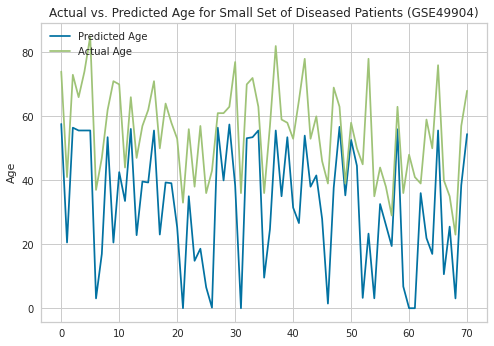

In [41]:
plt.plot(GSE49904_predictions)
plt.plot(GSE49904_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE49904)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

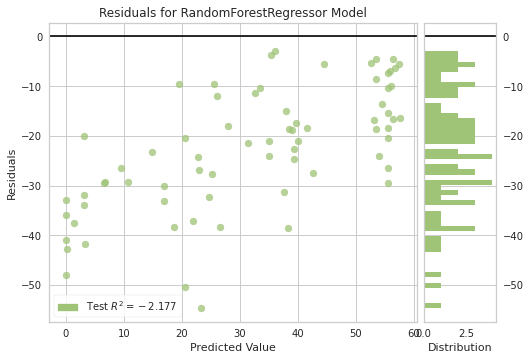

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [42]:
visualizer = ResidualsPlot(random_forest_regressor)

visualizer.score(GSE49904_X, GSE49904_Y)
visualizer.show()

The residual plot and line graph above shows that the average difference between predicted and actual age is negative (predicted age is less than actual age) for these aged individuals. This is interesting to see since it suggests that the blood of these individuals, for some reason shows methylation patterns more indicative of younger individuals. This could be a tissue-based difference, or might involve errors in the random forest regression model and its accuracy itself.

<a id='diseased_model_conclusion'></a>
## Conclusion
As can be seen above with the separate datasets above, the relationship between predicted and actual age of diseased individuals varies largely with the disease itself. More work and research into characterizing the profiles of each disease in terms of the effects they have on the epigenetic patterns is needed, along with more research into interventions like epigenetic reprogramming (resetting an abnormal epigenome to one characteristic of a healthier body) to slow the effects of ageing.

In [43]:
!pip install ibm_watson_machine_learning

In [44]:
from ibm_watson_machine_learning import APIClient
import numpy as np
import json


wml_cred = {
    "url" : "https://eu-de.ml.cloud.ibm.com",
    "apikey" : "ZHN54ifDpbzD4C7gkTkBctA5vqoSSDU6ux-MCXOgAnok" 
}

client = APIClient(wml_cred)

In [45]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ------  ------------------------
ID                                    NAME    CREATED
2c3ea710-8743-4cdd-af8e-7f986886aec2  Models  2022-10-08T17:27:21.245Z
------------------------------------  ------  ------------------------


In [46]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name) ['metadata']['id'])

In [47]:
space_uid = guid_from_space_name(client, 'Models')
print("Space UID: " + space_uid)

Space UID: 2c3ea710-8743-4cdd-af8e-7f986886aec2


In [48]:
client.set.default_space(space_uid)

'SUCCESS'

In [49]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
runtime-22.1-py3.9             12b83a1

In [50]:
software_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")
software_spec_uid

'e4429883-c883-42b6-87a8-f419d64088cd'

## Fit Model to Deployment

In [52]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [53]:
pipelines = {
    'rf':make_pipeline(RandomForestRegressor(random_state=1234)),
    'gb':make_pipeline(GradientBoostingRegressor(random_state=1234))
}

In [54]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
hypergrid = {
    'rf': {
        'randomforestregressor__min_samples_split':[2,4,6],
        'randomforestregressor__min_samples_leaf':[1,2,3]
    },
    'gb':{
        'gradientboostingregressor__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    }
}

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

In [57]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypergrid[algo], cv=10, n_jobs=1)
    try:
        print('Starting training for {}.'.format(algo))
        model.fit(X_train, y_train)
        fit_models[algo] = model
        print('{} has been successfully fit.'.format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.


In [58]:
from sklearn.metrics import r2_score, mean_absolute_error

for algo,model in fit_models.items():
    yhat = model.predict(X_test)
    print('{} scores - R2:{} MAE:{}'.format(algo, r2_score(y_test, yhat), mean_absolute_error(y_test, yhat)))

rf scores - R2:0.9403586555587945 MAE:2.93462127331551
gb scores - R2:0.9338145063768979 MAE:3.3193348846512536


In [59]:
best_model = fit_models['rf']
best_model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('randomforestregressor',
                                        RandomForestRegressor(random_state=1234))]),
             n_jobs=1,
             param_grid={'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [2, 4, 6]})

In [60]:
!pip install watson_machine_learning_client

     |████████████████████████████████| 538 kB 17.1 MB/s eta 0:00:01


In [62]:
# import joblib
from watson_machine_learning_client.utils import DEPLOYMENT_DETAILS_TYPE, INSTANCE_DETAILS_TYPE, print_text_header_h1, print_text_header_h2, STR_TYPE, STR_TYPE_NAME, docstring_parameter, str_type_conv, meta_props_str_conv, StatusLogger, convert_metadata_to_parameters
from watson_machine_learning_client.wml_client_error import WMLClientError, MissingValue, NoVirtualDeploymentSupportedForICP

In [63]:


# model_details = client.repository.store_model(model = best_model, meta_props = {
#      client.repository.ModelMetaNames.NAME: "Biological_Age_Pred",
#      client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
#      client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
     
# }
#                                              )

# model_id =client.repository.get_model_uid(model_details)

2022-10-09 09:21:10,571 - ibm_watson_machine_learning.wml_client_error - WARNING - Publishing model failed.
Reason: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 09 Oct 2022 09:21:10 GMT', 'Content-Type': 'application/json', 'Content-Length': '292', 'Connection': 'keep-alive', 'server-timing': 'intid;desc=fd2966d0d6471e2b, intid;desc=fd2966d0d6471e2b', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '75760b663a362778-PRG'})
HTTP response body: {
  "trace": "e80831583f72692f03ba32ed3867f469",
  "errors": [{
    "code": "invalid_request_entity",
    "message": "Invalid request entity: Unsupported software specification 'default_py3.7'.",
    "more_info": "https://cloud.ibm.com/apidocs/machine-learning"
  }],
  "status_code": "400"
}



Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 254, in _save_scikit_pipeline_model
    model_artifact = self._create_pipeline_model(artifact, query_param)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 514, in _create_pipeline_model
    model_artifact = self._create_pipeline_model_v4_cloud(model_artifact, query_param)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 1018, in _create_pipeline_model_v4_cloud
    model_output = self.repository_api.ml_assets_model_creation_v4_cloud(model_input, query_param,headers)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/swagger_client/apis/repository_api.py", line 301,

WMLClientError: Publishing model failed.
Reason: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 09 Oct 2022 09:21:10 GMT', 'Content-Type': 'application/json', 'Content-Length': '292', 'Connection': 'keep-alive', 'server-timing': 'intid;desc=fd2966d0d6471e2b, intid;desc=fd2966d0d6471e2b', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '75760b663a362778-PRG'})
HTTP response body: {
  "trace": "e80831583f72692f03ba32ed3867f469",
  "errors": [{
    "code": "invalid_request_entity",
    "message": "Invalid request entity: Unsupported software specification 'default_py3.7'.",
    "more_info": "https://cloud.ibm.com/apidocs/machine-learning"
  }],
  "status_code": "400"
}


2022-10-09 09:24:52,075 - ibm_watson_machine_learning.wml_client_error - WARNING - Publishing model failed.
Reason: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 09 Oct 2022 09:24:52 GMT', 'Content-Type': 'application/json', 'Content-Length': '277', 'Connection': 'keep-alive', 'server-timing': 'intid;desc=4715a95dcedbf9b6, intid;desc=4715a95dcedbf9b6', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '757610cfe8d4b38f-PRG'})
HTTP response body: {
  "trace": "d4f810123a6ea2bbd27311465654a691",
  "errors": [{
    "code": "invalid_request_entity",
    "message": "Invalid request entity: DataSource type s3 is not supported.",
    "more_info": "https://cloud.ibm.com/apidocs/machine-learning"
  }],
  "status_code": "400"
}



In [64]:
MODEL_NAME = 'Biological_Age_Pred'
DEPLOYMENT_NAME = 'Models '
BEST_MODEL = best_model

In [68]:
# Set Python Version
software_spec_uid = client.software_specifications.get_id_by_name('default_py3.7')

# Setup model meta
model_props = {
    client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23', 
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

#Save model
model_details = client.repository.store_model(
    model=BEST_MODEL, 
    meta_props=model_props, 
    training_data=X_train.head(), 
    training_target=y_train.head()
)

Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 254, in _save_scikit_pipeline_model
    model_artifact = self._create_pipeline_model(artifact, query_param)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 514, in _create_pipeline_model
    model_artifact = self._create_pipeline_model_v4_cloud(model_artifact, query_param)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 1018, in _create_pipeline_model_v4_cloud
    model_output = self.repository_api.ml_assets_model_creation_v4_cloud(model_input, query_param,headers)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/swagger_client/apis/repository_api.py", line 301,

WMLClientError: Publishing model failed.
Reason: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 09 Oct 2022 09:24:52 GMT', 'Content-Type': 'application/json', 'Content-Length': '277', 'Connection': 'keep-alive', 'server-timing': 'intid;desc=4715a95dcedbf9b6, intid;desc=4715a95dcedbf9b6', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '757610cfe8d4b38f-PRG'})
HTTP response body: {
  "trace": "d4f810123a6ea2bbd27311465654a691",
  "errors": [{
    "code": "invalid_request_entity",
    "message": "Invalid request entity: DataSource type s3 is not supported.",
    "more_info": "https://cloud.ibm.com/apidocs/machine-learning"
  }],
  "status_code": "400"
}
